In [3]:
import pandas as pd
from IPython.display import Image
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator

Instructions from course:

1- Download data for the transportation model.

2- Build the graph using the Python library.

3- Train the model parameters using data.

4- Answer the questions below.

5- Submit your code.

Age (A): It is recorded as young (young) for individuals below 30 years, adult (adult) for individuals between 30 and 60 years old, and old (old) for people older than 60.

Sex (S): The biological sex of individual, recorded as male (M) or female (F).

Education (E): The highest level of education or training completed by the individual, recorded either high school (high) or university degree (uni).

Occupation (O): It is recorded as an employee (emp) or a self employed (self) worker.

Residence (R): The size of the city the individual lives in, recorded as small (small) or big (big).

Travel (T): The means of transport favoured by the individual, recorded as car (car), train (train) or other (other)

In [5]:
# import data
data = pd.read_csv('https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv')

# alternatively we also have teh file locally
# data = pd.read_csv('../data/transportation_survey.csv')
data.head()

,A,S,E,O,R,T
0,adult,F,high,emp,small,train
1,young,M,high,emp,big,car
2,adult,M,uni,emp,big,other
3,old,F,uni,emp,big,car
4,young,F,uni,emp,big,car


Build the DAG

In [6]:
model = DiscreteBayesianNetwork([('A', 'E'), ('S', 'E'), ('E', 'R'), ('E', 'O'), ('O', 'T'), ('R', 'T')])

Verify the structure of the DAG.

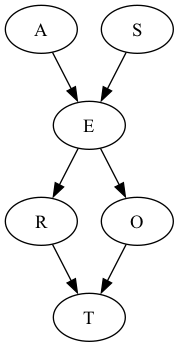

In [7]:
model_graphviz = model.to_graphviz()
model_graphviz.draw("week2dag.png", prog="dot")
Image("week2dag.png")

Fir the model parameters using data.

In [8]:
estimator = BayesianEstimator(model, data)
model.fit(
    data,
    estimator=BayesianEstimator,
    prior_type="dirichlet",
    pseudo_counts=1
) 

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'A': 'C', 'S': 'C', 'E': 'C', 'O': 'C', 'R': 'C', 'T': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'A': 'C', 'S': 'C', 'E': 'C', 'O': 'C', 'R': 'C', 'T': 'C'}


Examine the conditional probability distributions:

In [11]:
model.get_cpds()

[<TabularCPD representing P(A:3) at 0x10d288890>,
 <TabularCPD representing P(E:2 | A:3, S:2) at 0x31fbff650>,
 <TabularCPD representing P(R:2 | E:2) at 0x10d288950>,
 <TabularCPD representing P(O:2 | E:2) at 0x31ed63590>,
 <TabularCPD representing P(S:2) at 0x31fbea250>,
 <TabularCPD representing P(T:3 | O:2, R:2) at 0x31fc598d0>]

For example, we can look at the distribution of travel means (T) given the residence (R) and the occupation (O) of the individual.

In [20]:
cpd_T = model.get_cpds()[-1]

print(cpd_T.to_dataframe())

T                car     other     train
O    R                                  
emp  big    0.700730  0.136253  0.163017
     small  0.517647  0.094118  0.388235
self big    0.416667  0.333333  0.250000
     small  0.500000  0.250000  0.250000


For fun lets do inference... Suppose we have an individual that is young (A=young) and live sin a big city (R=big). What is the probability distribution of T?

In [21]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)
query = inference.query(['T'], evidence={"A": "young", "R": "big"})
print(query)

+----------+----------+
| T        |   phi(T) |
+==========+==========+
| T(car)   |   0.6935 |
+----------+----------+
| T(other) |   0.1412 |
+----------+----------+
| T(train) |   0.1652 |
+----------+----------+
